In [1]:
import os
import tensorflow as tf
import numpy as np
import math
import time
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

def load_satellite(num_training=4035, num_validation=400, num_test=2000):
    train = np.loadtxt('data/sat_train.txt')
    test = np.loadtxt('data/sat_test.txt')
    np.random.seed(0)
    np.random.shuffle(train)
    np.random.shuffle(test)
    
    X_train, y_train = train[:,:36],train[:,-1].astype(int)
    X_train = scale(X_train, np.min(X_train, axis=0), np.max(X_train, axis=0))
    
    X_test, y_test = test[:, :36], test[:,36].astype(int)
    X_test = scale(X_test, np.min(X_test, axis=0), np.max(X_test, axis=0))
    
    y_train[y_train == 7] = 6
    y_train -= 1
    
    y_test[y_test == 7] = 6
    y_test -= 1
    
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = load_satellite()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (4035, 36)
Train labels shape:  (4035,) int64
Validation data shape:  (400, 36)
Validation labels shape:  (400,)
Test data shape:  (2000, 36)
Test labels shape:  (2000,)


In [3]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        np.random.seed(0)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=True)
test_dset = Dataset(X_test, y_test, batch_size=64)

In [4]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (64, 36) (64,)
1 (64, 36) (64,)
2 (64, 36) (64,)
3 (64, 36) (64,)
4 (64, 36) (64,)
5 (64, 36) (64,)
6 (64, 36) (64,)


In [5]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /cpu:0


In [6]:
def two_layer_fc(x, params):
    """
    A fully-connected neural network; the architecture is:
    fully-connected layer -> ReLU -> fully connected layer.
    Note that we only need to define the forward pass here; TensorFlow will take
    care of computing the gradients for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.

    Inputs:
    - x: A TensorFlow Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of TensorFlow Tensors giving weights for the
      network, where w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A TensorFlow Tensor of shape (N, C) giving classification scores
      for the input data x.
    """
    w1, w2 = params  # Unpack the parameters
    h = tf.nn.sigmoid(tf.matmul(x, w1)) # Hidden layer: h has shape (N, H)
    scores = tf.matmul(h, w2)        # Compute scores of shape (N, C)
    return scores

In [7]:
def training_step(scores, y, params, learning_rate, beta=10**-6):
    """
    Set up the part of the computational graph which makes a training step.

    Inputs:
    - scores: TensorFlow Tensor of shape (N, C) giving classification scores for
      the model.
    - y: TensorFlow Tensor of shape (N,) giving ground-truth labels for scores;
      y[i] == c means that c is the correct class for scores[i].
    - params: List of TensorFlow Tensors giving the weights of the model
    - learning_rate: Python scalar giving the learning rate to use for gradient
      descent step.
      
    Returns:
    - loss: A TensorFlow Tensor of shape () (scalar) giving the loss for this
      batch of data; evaluating the loss also performs a gradient descent step
      on params (see above).
    """
    # First compute the loss; the first line gives losses for each example in
    # the minibatch, and the second averages the losses acros the batch
    
#     losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
#     loss = tf.reduce_mean(losses)


    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
    w1, w2 = params
    regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
    loss = tf.reduce_mean(cross_entropy + beta*regularization)


    # Compute the gradient of the loss with respect to each parameter of the the
    # network. This is a very magical function call: TensorFlow internally
    # traverses the computational graph starting at loss backward to each element
    # of params, and uses backpropagation to figure out how to compute gradients;
    # it then adds new operations to the computational graph which compute the
    # requested gradients, and returns a list of TensorFlow Tensors that will
    # contain the requested gradients when evaluated.
    grad_params = tf.gradients(loss, params)
    
    # Make a gradient descent step on all of the model parameters.
    new_weights = []   
    for w, grad_w in zip(params, grad_params):
        new_w = tf.assign_sub(w, learning_rate * grad_w)
        new_weights.append(new_w)

    # Insert a control dependency so that evaluting the loss causes a weight
    # update to happen; see the discussion above.
    with tf.control_dependencies(new_weights):
        return tf.identity(loss)

In [8]:
def train_part2(model_fn, init_fn, learning_rate, beta=10**-6, num_epochs=1, verbose=False):
                
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model
      using TensorFlow; it should have the following signature:
      scores = model_fn(x, params) where x is a TensorFlow Tensor giving a
      minibatch of image data, params is a list of TensorFlow Tensors holding
      the model weights, and scores is a TensorFlow Tensor of shape (N, C)
      giving scores for all elements of x.
    - init_fn: A Python function that initializes the parameters of the model.
      It should have the signature params = init_fn() where params is a list
      of TensorFlow Tensors holding the (randomly initialized) weights of the
      model.
    - learning_rate: Python float giving the learning rate to use for SGD.
    """
    # First clear the default graph
    tf.reset_default_graph()
    is_training = tf.placeholder(tf.bool, name='is_training')
    # Set up the computational graph for performing forward and backward passes,
    # and weight updates.
    with tf.device(device):
        # Set up placeholders for the data and labels
        x = tf.placeholder(tf.float32, [None, 36])
        y = tf.placeholder(tf.int32, [None])
        params = init_fn()           # Initialize the model parameters
        scores = model_fn(x, params) # Forward pass of the model
        loss = training_step(scores, y, params, learning_rate, beta)

    errors = []
    accuracies = []
    # Now we actually run the graph many times using the training data
    with tf.Session() as sess:
        # Initialize variables that will live in the graph
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
            for x_np, y_np in train_dset:
                # Run the graph on a batch of training data; recall that asking
                # TensorFlow to evaluate loss will cause an SGD step to happen.
                feed_dict = {x: x_np, y: y_np}
                loss_np = sess.run(loss, feed_dict=feed_dict)
                t += 1
            accuracy = check_accuracy(sess, val_dset, x, scores, is_training=is_training)
            errors.append(loss_np)
            accuracies.append(accuracy)
                # Periodically print the loss and check accuracy on the val set
            if verbose:
                print('Iteration %d, loss = %.4f' % (t, loss_np))
    return errors, accuracies
        

In [9]:
def check_accuracy(sess, dset, x, scores, is_training=None, verbose=False):
    """
    Check accuracy on a classification model.
    
    Inputs:
    - sess: A TensorFlow Session that will be used to run the graph
    - dset: A Dataset object on which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - scores: A TensorFlow Tensor representing the scores output from the
      model; this is the Tensor we will ask TensorFlow to evaluate.
      
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

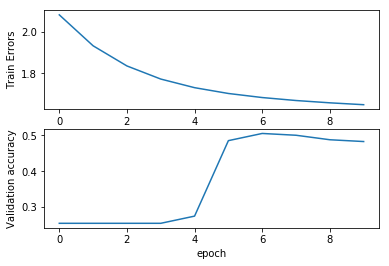

In [10]:
def two_layer_fc_init():
    """
    Initialize the weights of a two-layer network, for use with the
    two_layer_network function defined above.
    
    Inputs: None
    
    Returns: A list of:
    - w1: TensorFlow Variable giving the weights for the first layer
    - w2: TensorFlow Variable giving the weights for the second layer
    """
    
    w1 = tf.Variable(tf.truncated_normal([num_features, hidden_layer_size], stddev=1.0/math.sqrt(float(num_features)),seed=0))
    w2 = tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], stddev=1.0/math.sqrt(float(hidden_layer_size)),seed=0))
    return [w1, w2]
                     
num_features = 36
num_classes = 6
learning_rate = 10**-2
hidden_layer_size = 10
errors, accuracies = train_part2(two_layer_fc, two_layer_fc_init, learning_rate, num_epochs=10)
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
ax1.plot(range(len(errors)), errors)
ax2.plot(range(len(accuracies)), accuracies)
plt.xlabel('epoch')
ax1.set_ylabel('Train Errors')
ax2.set_ylabel('Validation accuracy')
plt.show()

In [11]:
def plot_err_acc(err, acc, hyperparam, label):
    n = len(hyperparam)
    num_epoch = len(err[0])
    fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1) 
    for i in range(n):
        ax1.plot(range(num_epoch), err[i], label='{} = {}'.format(label, hyperparam[i]))
        ax2.plot(range(num_epoch), acc[i], label='{} = {}'.format(label, hyperparam[i]))

    plt.xlabel('epoch')
    ax1.set_ylabel('Train Errors')
    ax2.set_ylabel('Validation accuracy')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [12]:
def plot_time(times, hyperparam, label):
    plt.figure()
    plt.plot(hyperparam, times)
    plt.scatter(hyperparam, times)
    plt.xlabel(label)
    plt.ylabel('time')
    for i, time in enumerate(times):
        plt.annotate("%.3f"%(time), (hyperparam[i], times[i]))
    plt.show()

batch size: 4
batch size: 8
batch size: 16
batch size: 32
batch size: 64


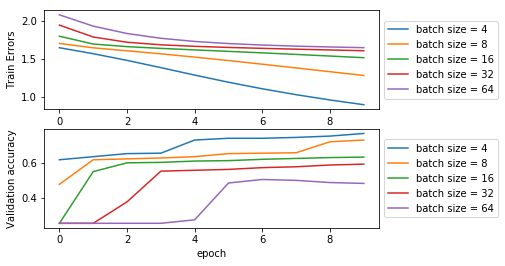

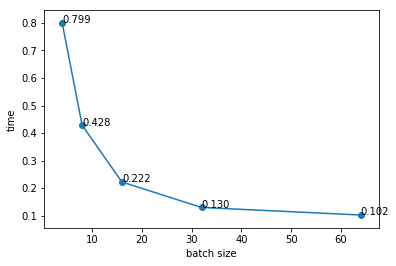

In [13]:
batch_sizes = [4, 8, 16, 32, 64]
num_epoch = 10
acc = []
err = []
times = []
for size in batch_sizes:
    print('batch size:', size)
    train_dset = Dataset(X_train, y_train, batch_size=size, shuffle=True)
    val_dset = Dataset(X_val, y_val, batch_size=size, shuffle=True)
    test_dset = Dataset(X_test, y_test, batch_size=size)
    tic = time.time()
    errors, accuracies = train_part2(two_layer_fc, two_layer_fc_init, learning_rate, num_epochs=num_epoch)
    toc = time.time()
    acc.append(accuracies)
    err.append(errors)
    times.append((toc - tic)/num_epoch)
plot_err_acc(err, acc, batch_sizes, 'batch size')
plot_time(times, batch_sizes, 'batch size')

hidden size: 5
hidden size: 10
hidden size: 15
hidden size: 20
hidden size: 25


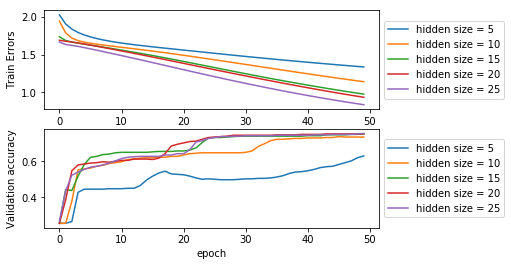

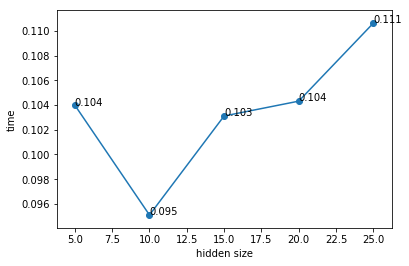

In [17]:
train_dset = Dataset(X_train, y_train, batch_size=32, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=32, shuffle=True)
test_dset = Dataset(X_test, y_test, batch_size=32)

hidden_sizes = [5, 10, 15, 20, 25]
num_epoch = 50
acc = []
err = []
times = []
for size in hidden_sizes:
    print('hidden size:', size)
    hidden_layer_size = size
    tic = time.time()
    errors, accuracies = train_part2(two_layer_fc, two_layer_fc_init, learning_rate, num_epochs=num_epoch)
    toc = time.time()
    acc.append(accuracies)
    err.append(errors)
    times.append((toc - tic)/num_epoch)
plot_err_acc(err, acc, hidden_sizes, 'hidden size')
plot_time(times, hidden_sizes, 'hidden size')

decay: 0
decay: 0.001
decay: 1e-06
decay: 1e-09
decay: 1e-12


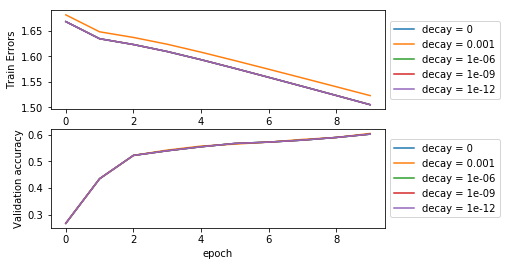

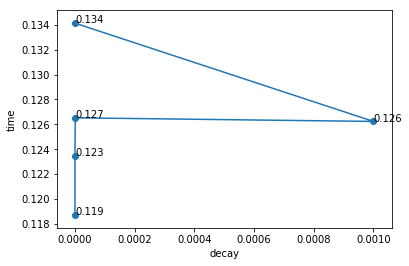

In [16]:
decay_params = [0, 1e-3, 1e-6, 1e-9, 1e-12]
num_epoch = 10
acc = []
err = []
times = []
for decay in decay_params:
    print('decay:', decay)
    tic = time.time()
    errors, accuracies = train_part2(two_layer_fc, two_layer_fc_init, learning_rate, decay, num_epochs=num_epoch)
    toc = time.time()
    acc.append(accuracies)
    err.append(errors)
    times.append((toc - tic)/num_epoch)
plot_err_acc(err, acc, decay_params, 'decay')
plot_time(times, decay_params, 'decay')

Questions:
- need validation set?